## Asset-Backed Securities Assignment
### Calibrating the Hull-White model and pricing REMIC bonds

This project focuses on pricing REMIC pass-through bonds that were offered by Freddie Mac in 2003/2004. We first calibrated the one-factor Hull-White model to at-the-money cap data as of the settlement date of the issuance. With this term structure model, we generated 5,000 interest rate paths over 30 years (and used antithetic variates to generate 5,000 "more" paths). For every realized path in the simulation, we calculated the cashflows to each bond (using rates at each point in time for each path to estiamte prepayment rates) and then discounted the cashflows for each bond along each interest rate realization. Finally, we averaged the prices across all simulations to get estimates of what each bond should be priced at and the simualated effective durations and convexities.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.stats import norm
from scipy.optimize import minimize, fsolve
from scipy.interpolate import interp1d

%matplotlib inline

In [2]:
# change default plotting
mpl.style.use('seaborn-whitegrid')
mpl.rcParams['axes.grid.axis'] = 'both'
mpl.rcParams['grid.linestyle'] = '--'
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.bottom'] = False
mpl.rcParams['axes.spines.left'] = False
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['savefig.dpi'] = 150
mpl.rcParams['figure.figsize'] = [7, 5]
# mpl.rcParams.keys()

# 1

In [3]:
# load in rates downloaded directly from bloomberg
df = pd.read_csv('grid1_1sxnf1gf.csv')
df['Date'] = pd.to_datetime(df['Date'])
df[['Zero Rate', 'Forward Rate']] /= 100

# differences in days between setlements
df['tau_days'] = df['Date'].diff().dt.days.fillna(0)
df['T_days'] = df['tau_days'].cumsum()
df.head()

,Date,Zero Rate,Forward Rate,tau_days,T_days
0,2004-09-01,0.000000,0.017900,0.0,0.0
1,2004-12-01,0.018108,0.021879,91.0,91.0
2,2005-03-01,0.020104,0.024134,90.0,181.0
3,2005-06-01,0.021550,0.026752,92.0,273.0
4,2005-09-01,0.022931,0.029241,92.0,365.0


### 1.a + 1.b Calculate discount factors and forward rates from the semi-annually compounded zero rates

In [4]:
df['disc_factor'] = np.exp(-df['Zero Rate'] * df['T_days']/365)
df['fwd_rate_simple'] = (1 / (df['tau_days'] / 360)) * (df['disc_factor'].shift(1) / df['disc_factor'] - 1)
df.head()

,Date,Zero Rate,Forward Rate,tau_days,T_days,disc_factor,fwd_rate_simple
0,2004-09-01,0.000000,0.017900,0.0,0.0,1.000000,NaN
1,2004-12-01,0.018108,0.021879,91.0,91.0,0.995496,0.017900
2,2005-03-01,0.020104,0.024134,90.0,181.0,0.990080,0.021879
3,2005-06-01,0.021550,0.026752,92.0,273.0,0.984011,0.024134
4,2005-09-01,0.022931,0.029241,92.0,365.0,0.977330,0.026752


### 1.c Calculate ATM strike rates for each of the 15 caps

In [5]:
swap_num = (df['tau_days']/360 * df['fwd_rate_simple'] * df['disc_factor'])
swap_denom = (df['tau_days']/360 * df['disc_factor'])

swap_num.iloc[:2] = 0
swap_denom.iloc[:2] = 0

df['swap_rate'] = swap_num.cumsum() / swap_denom.cumsum()
cap_maturities = list(range(4, 44, 4)) + [48, 60, 80, 100, 120]
swap_rates = df.loc[cap_maturities, ['swap_rate']]
df

,Date,Zero Rate,Forward Rate,tau_days,T_days,disc_factor,fwd_rate_simple,swap_rate
0,2004-09-01,0.000000,0.017900,0.0,0.0,1.000000,NaN,NaN
1,2004-12-01,0.018108,0.021879,91.0,91.0,0.995496,0.017900,NaN
2,2005-03-01,0.020104,0.024134,90.0,181.0,0.990080,0.021879,0.021879
3,2005-06-01,0.021550,0.026752,92.0,273.0,0.984011,0.024134,0.023015
4,2005-09-01,0.022931,0.029241,92.0,365.0,0.977330,0.026752,0.024262
...,...,...,...,...,...,...,...,...
117,2033-12-01,0.055559,0.055173,91.0,10683.0,0.196692,0.055188,0.052878
118,2034-03-01,0.055559,0.055175,90.0,10773.0,0.194016,0.055173,0.052885
119,2034-06-01,0.055558,0.055171,92.0,10865.0,0.191318,0.055175,0.052892
120,2034-09-01,0.055558,0.055166,92.0,10957.0,0.188658,0.055171,0.052900


### 1.d Calibrate a one-factor Hull-White model to the ATM caps data

#### Black price of European cap

In [6]:
# read in caps data
euro_caps = pd.read_excel('20040830_usd23_atm_caps_2021.xlsx', sheet_name='usd_atm_european_caps', skiprows=2, engine='openpyxl')
euro_caps['Expiry'] = pd.to_numeric(euro_caps['Expiry'].str[:-2])

# get expirations in months
euro_caps.index = euro_caps['Expiry'] * 4
euro_caps.index.rename('Expiry_m', inplace=True)
euro_caps.drop('Expiry', axis=1, inplace=True)
euro_caps.columns = ['Black Flat Vol', 'Strike Rate']
euro_caps

/opt/miniconda3/envs/default_env/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,Black Flat Vol,Strike Rate
Expiry_m,,
4,0.2965,0.024262
8,0.3530,0.029149
12,0.3335,0.033024
16,0.3115,0.036133
20,0.2915,0.038719
24,0.2770,0.040851
28,0.2645,0.042529
32,0.2525,0.044039
36,0.2420,0.045260


In [7]:
# load in expiry dates and convert to datetime
caplet_exp_date = pd.read_excel('20040830_usd23_atm_caps_2021.xlsx', sheet_name='usd23_libor_curve', header=3)
caplet_exp_date = caplet_exp_date['Caplet Accrual Expiry Date'][1:-1]
caplet_exp_date = caplet_exp_date.reset_index(drop=True)

# convert to dataframe and rename
caplet_df = pd.DataFrame(caplet_exp_date)
caplet_df.columns = ['Exp Date']

# set first expiry date to settlement date for simplicity
settlement_date = pd.to_datetime('2004-09-01')
caplet_df = pd.DataFrame(pd.concat([pd.Series(settlement_date), caplet_df['Exp Date']]), columns=['Exp Date']).reset_index(drop=True)
caplet_df

/opt/miniconda3/envs/default_env/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,Exp Date
0,2004-09-01
1,2004-11-29
2,2005-02-25
3,2005-05-27
4,2005-08-30
...,...
116,2033-08-30
117,2033-11-29
118,2034-02-27
119,2034-05-30


In [8]:
# compute expiry year fraction (ACT/365) and payment year fraction (ACT/360)
settlement_date = caplet_df['Exp Date'][0]
caplet_df['exp_year_fract'] = (caplet_df['Exp Date'] - settlement_date).dt.days / 365
caplet_df['pmt_year_fract'] = df['Date'].diff().dt.days.shift(-1) / 360
caplet_df.index.rename = ['caplet_num']
caplet_df.head()

,Exp Date,exp_year_fract,pmt_year_fract
0,2004-09-01,0.000000,0.252778
1,2004-11-29,0.243836,0.250000
2,2005-02-25,0.484932,0.255556
3,2005-05-27,0.734247,0.255556
4,2005-08-30,0.994521,0.252778


In [9]:
# merge to get caplet volatilities
caplet_df = caplet_df.merge(euro_caps[['Black Flat Vol']], left_index=True, right_index=True, how='left')

# merge to get strike rates
caplet_df = caplet_df.merge(df[['swap_rate']], left_index=True, right_index=True, how='left')

# merge to get forward rates and discount rates
caplet_df = caplet_df.merge(df[['Forward Rate']], left_index=True, right_index=True, how='left')
caplet_df = caplet_df.merge(df[['disc_factor']].shift(-1), left_index=True, right_index=True, how='left')
caplet_df

,Exp Date,exp_year_fract,pmt_year_fract,Black Flat Vol,swap_rate,Forward Rate,disc_factor
0,2004-09-01,0.000000,0.252778,NaN,NaN,0.017900,0.995496
1,2004-11-29,0.243836,0.250000,NaN,NaN,0.021879,0.990080
2,2005-02-25,0.484932,0.255556,NaN,0.021879,0.024134,0.984011
3,2005-05-27,0.734247,0.255556,NaN,0.023015,0.026752,0.977330
4,2005-08-30,0.994521,0.252778,0.2965,0.024262,0.029241,0.970159
...,...,...,...,...,...,...,...
116,2033-08-30,29.013699,0.252778,NaN,0.052870,0.055188,0.196692
117,2033-11-29,29.263014,0.250000,NaN,0.052878,0.055173,0.194016
118,2034-02-27,29.509589,0.255556,NaN,0.052885,0.055175,0.191318
119,2034-05-30,29.761644,0.255556,NaN,0.052892,0.055171,0.188658


In [10]:
print('We are interested in cap values with the following maturities (in quarters):\n', cap_maturities)
print()

def calc_cap_vals_black(caplet_df, cap_maturities):
    # loop through cap maturities and calculate cap values
    cap_vals_black = []
    for exp in cap_maturities:

        # get subset of data based on cap maturity 
        caplet_tmp = caplet_df.loc[:exp-1,:]

        # parameters for given cap/caplets
        swap_rate = caplet_df.loc[exp, 'swap_rate']
        black_vol = caplet_df.loc[exp, 'Black Flat Vol']
        caplet_vols = np.sqrt(caplet_tmp['exp_year_fract']) * black_vol

        # value caplets
        notional = 10000000
        log_fx = np.log(caplet_tmp['Forward Rate'] / swap_rate)
        Nd1 = (log_fx + 0.5 * caplet_vols**2) / caplet_vols
        Nd2 = (log_fx - 0.5 * caplet_vols**2) / caplet_vols
        phi1 = norm.cdf(Nd1)
        phi2 = norm.cdf(Nd2)
        payment = caplet_tmp['pmt_year_fract'] * notional * (caplet_tmp['Forward Rate'] * phi1 - swap_rate * phi2)
        pv = payment * caplet_tmp['disc_factor']

        # value of cap is sum of present values of caplets
        cap_val = sum(pv)
        cap_vals_black.append([exp/4, cap_val])


    cap_vals_black = pd.DataFrame(cap_vals_black, columns=['Cap Maturity', 'Value']).set_index('Cap Maturity')
    return cap_vals_black

cap_maturities = list(range(4, 44, 4)) + [48, 60, 80, 100, 120]
cap_vals_black = calc_cap_vals_black(caplet_df, cap_maturities)
cap_vals_black

We are interested in cap values with the following maturities (in quarters):
 [4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 48, 60, 80, 100, 120]



,Value
Cap Maturity,
1.0,1.604021e+04
2.0,7.824091e+04
3.0,1.614619e+05
4.0,2.552176e+05
5.0,3.543129e+05
6.0,4.575667e+05
7.0,5.579451e+05
8.0,6.573149e+05
9.0,7.498995e+05


#### Hull-White price of European cap

In [11]:
def calc_cap_vals_white(caplet_df, params):
    # loop through cap maturities and calculate cap values
    cap_vals_white = []
    for exp in cap_maturities:

        # get subset of data based on cap maturity 
        caplet_tmp = caplet_df.loc[:exp-1,:]

        # parameters for given cap/caplets
        swap_rate = caplet_df.loc[exp, 'swap_rate']
        kappa, sigma = params

        # value caplets
        notional = 10000000
        B = (1 / kappa) * (1 - np.exp(-kappa * caplet_tmp['pmt_year_fract']))
        sigma_p = sigma * np.sqrt((1 - np.exp(-2*kappa*caplet_tmp['exp_year_fract'])) / (2 * kappa)) * B
        h = (1 / sigma_p) * np.log((caplet_tmp['disc_factor'] * (1 + swap_rate * caplet_tmp['pmt_year_fract'])) / caplet_tmp['disc_factor'].shift(1)) + sigma_p / 2

        caplet_vals_white = notional * (caplet_tmp['disc_factor'].shift(1) * norm.cdf(-h + sigma_p) - (1 + swap_rate * caplet_tmp['pmt_year_fract']) * caplet_tmp['disc_factor'] * norm.cdf(-h))

        # value of cap is sum of present values of caplets
        cap_val_white = sum(caplet_vals_white.fillna(0))
        cap_vals_white.append([exp/4, cap_val_white])
        
    
    cap_vals_white = pd.DataFrame(cap_vals_white, columns=['Cap Maturity', 'Value']).set_index('Cap Maturity')
    return cap_vals_white

In [12]:
def hw_opt(params):
    # hull-white cap values guess
    cap_vals_white_tmp = calc_cap_vals_white(caplet_df, params)
    
    # objective function
    obj = np.sqrt(sum((cap_vals_black['Value'].values - cap_vals_white_tmp['Value'].values)**2))
    
    return obj

result = minimize(hw_opt, [0.1, 0.1])
result

      fun: 60165.57814363537
 hess_inv: array([[2.47760011e-08, 1.02893273e-09],
       [1.02893273e-09, 4.42882167e-11]])
      jac: array([  552.83056641, -9198.61523438])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 156
      nit: 9
     njev: 49
   status: 2
  success: False
        x: array([0.11470186, 0.01456556])

In [13]:
print('Hull-White fitted parameters: kappa = {0:.4f}, sigma={1:.4f}'.format(result.x[0], result.x[1]))

Hull-White fitted parameters: kappa = 0.1147, sigma=0.0146


In [14]:
cap_vals_white = calc_cap_vals_white(caplet_df, result.x)
cap_vals_white

,Value
Cap Maturity,
1.0,2.924893e+04
2.0,9.621642e+04
3.0,1.808908e+05
4.0,2.732883e+05
5.0,3.694676e+05
6.0,4.659540e+05
7.0,5.594252e+05
8.0,6.521237e+05
9.0,7.392019e+05


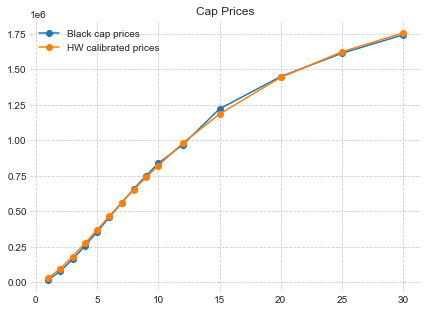

In [15]:
plt.figure(figsize=(7,5))
plt.plot(cap_vals_black, 'o-', label='Black cap prices')
plt.plot(cap_vals_white, 'o-', label='HW calibrated prices')
plt.title('Cap Prices')
plt.legend();

### 1.e Estimate theta from the Hull-White model

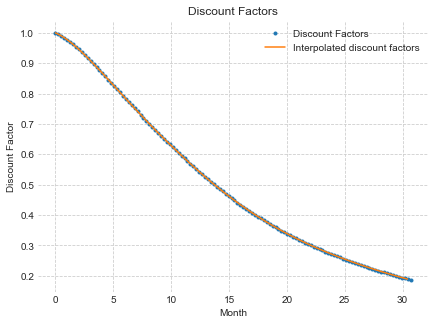

In [16]:
# fit quarterly discount factors
x = df["T_days"] / 360
y = df["disc_factor"].values
f = interp1d(x, y, kind = 'cubic')

# compute the interpolated monthly discount factors
xnew = np.arange(0, 30 + 6/12, 1/12)
disc_factor_interp = f(xnew)

# convert to dataframe
disc_interp_df = pd.DataFrame([xnew, disc_factor_interp]).T
disc_interp_df.columns = ['Maturity_m', 'disc_factor']
disc_interp_df.set_index('Maturity_m', inplace=True)

# plot the discount factors
plt.figure(figsize=(7,5))
plt.plot(x, y, '.', label='Discount Factors')
plt.plot(disc_interp_df, '-', label='Interpolated discount factors')
plt.title('Discount Factors')
plt.xlabel('Month')
plt.ylabel('Discount Factor')
plt.legend();

,theta
Maturity_m,
0.000000,0.023960
0.083333,0.023960
0.166667,0.023960
0.250000,0.021111
0.333333,0.018221
0.416667,0.015286
0.500000,0.012303
0.583333,0.009990
0.666667,0.010828


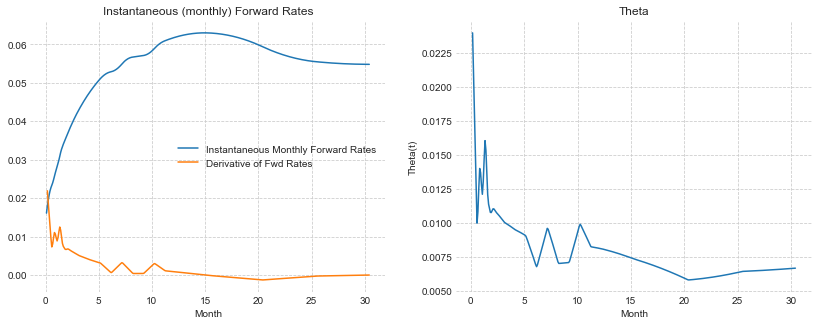

In [17]:
kappa, sigma = result.x[0], result.x[1]

# calculate theta
ins_fwd = -(np.log(disc_interp_df) - np.log(disc_interp_df.shift(1))) / (1/12)
d_ins_fwd = ins_fwd.diff(1) / (1/12)
theta = d_ins_fwd + kappa * ins_fwd + (sigma**2 / (2 * kappa)) * (1 - np.exp(-2*kappa*np.reshape(ins_fwd.index, [-1, 1])/12))

# plotting
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
axs[0].plot(ins_fwd, label='Instantaneous Monthly Forward Rates')
axs[0].plot(d_ins_fwd, label='Derivative of Fwd Rates')
axs[0].set_title('Instantaneous (monthly) Forward Rates')
axs[0].set_xlabel('Month')
axs[0].legend()

axs[1].plot(theta)
axs[1].set_title('Theta')
axs[1].set_xlabel('Month')
axs[1].set_ylabel('Theta(t)')

# format df and backfill due to nan's introduced from derivative approximations
theta.columns = ['theta']
theta.backfill(inplace=True)
theta.head(10)

In [18]:
# calculate continuous zero rates from discount factors (needed later for initial short rate)
disc_interp_df['Zero Rate'] = -(1/disc_interp_df.index) * np.log(disc_interp_df['disc_factor'])

# shift back zero rate for correct alignment
disc_interp_df['Zero Rate'] = disc_interp_df['Zero Rate'].shift(-1)
disc_interp_df.head()

,disc_factor,Zero Rate
Maturity_m,,
0.000000,1.000000,0.016092
0.083333,0.998660,0.017005
0.166667,0.997170,0.017833
0.250000,0.995552,0.018577
0.333333,0.993827,0.019237


### 1.f (extra credit) Compare the Hull-White implied volatilities to the Black implied volatilities

In [19]:

def implied_black_vol(cap_vals_white, caplet_df):
    # loop through cap maturities and calculate cap values
    implied_vols = []

    for i in range(cap_vals_white.shape[0]):

        exp = cap_maturities[i]

        # get subset of data based on cap maturity 
        caplet_tmp = caplet_df.loc[:exp-1,:]

        # parameters for given cap/caplets
        swap_rate = caplet_df.loc[exp, 'swap_rate']
        
        # value caplets
        notional = 10000000
        log_fx = np.log(caplet_tmp['Forward Rate'] / swap_rate)
        
        # Solve for the implied volatility 
        f = lambda vol: cap_vals_white.values[i] - sum(caplet_tmp['pmt_year_fract'] * notional * (caplet_tmp['Forward Rate'] * norm.cdf((log_fx + 0.5 * (np.sqrt(caplet_tmp['exp_year_fract']) * vol) **2) / (np.sqrt(caplet_tmp['exp_year_fract']) * vol)) - swap_rate * norm.cdf(((log_fx - 0.5 * (np.sqrt(caplet_tmp['exp_year_fract']) * vol) **2) / (np.sqrt(caplet_tmp['exp_year_fract']) * vol)))) * caplet_tmp['disc_factor'])
        implied_vol = fsolve(f, 0)[0] * 100 # 0 is a random initial guess
        implied_vols.append([exp/4, implied_vol])

    implied_vols = pd.DataFrame(implied_vols, columns=['Cap Maturity', 'Implied Black Volatility']).set_index('Cap Maturity')
    return implied_vols

In [20]:
implied_vol = implied_black_vol(cap_vals_white, caplet_df)
implied_vol

,Implied Black Volatility
Cap Maturity,
1.0,57.692835
2.0,45.749696
3.0,38.704590
4.0,34.126691
5.0,30.840557
6.0,28.386182
7.0,26.544063
8.0,24.983768
9.0,23.741514


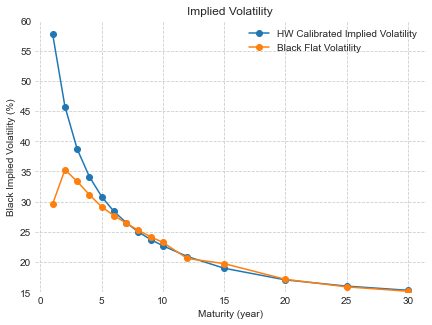

In [21]:
# Plot the discount factors
plt.figure(figsize=(7,5))
plt.plot(implied_vol, 'o-', label='HW Calibrated Implied Volatility')
plt.plot(euro_caps.index.values/4, euro_caps['Black Flat Vol'].values*100, 'o-', label='Black Flat Volatility')
plt.title('Implied Volatility')
plt.ylabel('Black Implied Volatility (%)')
plt.xlabel('Maturity (year)')
plt.ylim((15,60))
plt.legend();

# 2. Pricing REMIC Bonds

In [22]:
# Import pool data
pool_df = pd.read_excel('REMIC_Template.xlsx', sheet_name='Pool Info', header = 1 )
pool_df = pool_df.dropna()

# Change column name
pool_index = np.array(['Pool_num', 'CUSIP', 'UPB_whole', 'UPB_original', 'UPB_current', 'WAC', 'Coupon', 'Issue_Y', 'Issue_M', 'Issue_D', 'PMT_Y', 'PMT_M', 'PMT_D', 'WARM', 'WALA', 'Group_ID'])
pool_df.columns = pool_index

# Convert the given issue date and maturity date into datetime object
temp_df = pool_df[['Issue_Y', 'Issue_M', 'Issue_D']]
temp_df.columns = ['year', 'month', 'day']
pool_df['Issue_date'] = pd.to_datetime(temp_df)
temp_df = pool_df[['PMT_Y', 'PMT_M', 'PMT_D']]
temp_df.columns = ['year', 'month', 'day']
pool_df['Maturity_date'] = pd.to_datetime(temp_df)

pool_df = pool_df.drop(['Issue_Y', 'Issue_M', 'Issue_D', 'PMT_Y', 'PMT_M', 'PMT_D'], axis=1)

pool_df

/opt/miniconda3/envs/default_env/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,Pool_num,CUSIP,UPB_whole,UPB_original,UPB_current,WAC,Coupon,WARM,WALA,Group_ID,Issue_date,Maturity_date
0,C90831,31335H4Q3,1.343640e+09,78512127.0,7.765766e+07,5.402,5.0,236.0,3.0,1.0,2004-05-01,2024-05-01
1,C90836,31335H4V2,7.824198e+08,129691394.0,1.288423e+08,5.419,5.0,237.0,3.0,1.0,2004-06-01,2024-06-01


In [23]:
print('CMO tranches:')

tranche = {'CG': [74.80 * 1000000, 0.05],
           'VE': [ 5.20 * 1000000, 0.05],
           'CM': [14.00 * 1000000, 0.05],
           'GZ': [22.00 * 1000000, 0.05],
           'TC': [20.00 * 1000000, 0.05],
           'CZ': [24.00 * 1000000, 0.05],
           'CA': [32.55 * 1000000, 0.05],
           'CY': [13.95 * 1000000, 0.05],
           'R' : [              0,    0]
}

tranche_data = pd.DataFrame(tranche, index = ['principal', 'coupon']).T
tranche_data

CMO tranches:


,principal,coupon
CG,74800000.0,0.05
VE,5200000.0,0.05
CM,14000000.0,0.05
GZ,22000000.0,0.05
TC,20000000.0,0.05
CZ,24000000.0,0.05
CA,32550000.0,0.05
CY,13950000.0,0.05
R,0.0,0.00


### 2.a Price each of the REMIC bonds using Monte Carlo simulations (10,000 paths)

In [24]:
class CashflowSim:
    """Run Monte Carlo simulations for cash flows from mortgage pools
    
    Usage:
        1. instantiate CashflowSim object
        2. generate interest rate path simulations and antithetics with short_rate_sim
        3. simulate cashflows for interest rate paths (and antithetics) with pool_cashflows_sim
        4. get prices of tranches based on simulated cash flows for each path using tranche_cashflows_sim 

    Args:
        r_0: the current short rate
        sigma: Hull-White volatility of interest rates
        kappa: mean-reversion speed parameter
        theta: a df or series of thetas throughout time, determining what r reverts to
        year: number of years to run each simulation for
        period (default 12): number of periods per year
        num_paths (default 10000): number of paths to generate 
        seed (default 1): seed for random number generator
    """

    def __init__(self, r_0, sigma, kappa, theta, year, period=12, num_paths=10000, seed=1):
        self.r_0 = r_0
        self.sigma = sigma
        self.kappa = kappa
        self.theta = theta
        self.year = year
        self.period = period
        self.num_paths = num_paths
        np.random.seed(seed)
        self.pools = [[], []] # used to store pool CFs for regular and antithetic samples
        self.prices = [] # used to store simulated prices

        # initiliazed later on
        self.short_rates = None
        self.short_rates_at = None
        self.yields_10yr = None
        self.yields_10yr_at = None

        # draw random samples at the start
        self.norm_smpls = np.random.normal(0, 1, size=(self.num_paths, self.year * self.period + 1))
        self.antithetic = - self.norm_smpls


    def short_rate_sim(self):
        """Returns num_paths number of sims + antithetics for the short rate using Hull-White model"""
        
        # setup
        T = self.year * self.period + 1
        assert T < self.theta.shape[0], 'Number of total periods for simulation must be less than periods of theta'
        delta_t = 1 / self.period
        sim_size = (self.num_paths, T)
        
        # initialize arrays for short rate and with antithetic variates
        short_rates = np.zeros(sim_size)
        short_rates_at = np.zeros(sim_size)
        short_rates[:,0] = self.r_0
        short_rates_at[:,0] = self.r_0
        
        # generate short rate paths
        for i in range(1, T):
            short_rates[:,i] = short_rates[:,i-1] + (theta.iloc[i-1].values - kappa * short_rates[:,i-1]) * delta_t + sigma * np.sqrt(delta_t) * self.norm_smpls[:,i]
            short_rates_at[:,i] = short_rates_at[:,i-1] + (theta.iloc[i-1].values - kappa * short_rates_at[:,i-1]) * delta_t + sigma * np.sqrt(delta_t) * self.antithetic[:,i]
        self.short_rates =  pd.DataFrame(short_rates.T, index=np.arange(0, self.year + delta_t, delta_t))
        self.short_rates_at = pd.DataFrame(short_rates_at.T, index=np.arange(0, self.year + delta_t, delta_t))

        # calculate 10-year yields at each month for each simulation
        yields_10yr = []
        yields_10yr_at = []
        t_range = np.arange(0, 20.5, 1/12) # only have 30 years of values for theta
        for t in t_range:
            yields_10yr.append(self.white_zero_rate(self.short_rates.loc[t, :], t, 10).values)
            yields_10yr_at.append(self.white_zero_rate(self.short_rates_at.loc[t, :], t, 10).values)
        self.yields_10yr = pd.DataFrame(yields_10yr, index=t_range)
        self.yields_10yr_at = pd.DataFrame(yields_10yr_at, index=t_range)

        return [self.short_rates, self.short_rates_at]
    

    def white_zero_rate(self, r_0, start, maturity=10):
        """Returns the Hull-White yield of a ZCB for given maturity (default 10 years)"""
        
        assert maturity in theta.index.values, 'Maturity date not in time index of theta'

        # time indices
        ts = self.theta.loc[start:(start+maturity),'theta'].index.values
        
        # HW formula for yield of zcb
        B = (1 - np.exp(-self.kappa * ts)) / self.kappa
        B_T = B[-1]
        A = - sum(B * self.theta.loc[start:(start+maturity),'theta'] * (1/self.period)) + (self.sigma**2 / (2 * self.kappa**2)) * (maturity + (1 - np.exp(-2 * self.kappa * maturity)) / (2 * self.kappa) - 2 * B_T)
        r = - A / maturity + (1 / self.kappa) * ((1 - np.exp(-self.kappa * maturity)) / maturity) * r_0
        
        return r


    def pool_cashflows(self, init_bals, wacs, terms, ages, yields_10_yr):
        """Returns DF of sum of expected cashflows for given pools until maturity for a path of rates
        
        Args (all input as lists except yields_10_yr):
            init_bals: the initial balances of the pools
            wacs: weighted-average coupons of the pools (in percent, i.e. 0.05)
            terms: number of periods until each pool has fully paid out
            ages: starting age of the pools
            yields_10_yr: DF or series of one realization of int rate path of 10 year yields (monthly)
            
        Returns:
            DataFrame of sum of expected cashflows for a list of pools
        """
        
        # calculate cashflows for each pool
        pools_cf = []
        for pool in range(len(init_bals)):
            # params for each pool
            init_bal = init_bals[pool]
            wac = wacs[pool]
            term = terms[pool]
            age = ages[pool]

            # coupon rate per period
            periodic_wac = wac / self.period

            # starting values for df
            eom_bal = init_bal
            pool_cf = [[0, 0, 0, eom_bal]]
            
            # run loop to calculate payments/balances each month
            for month in range(1, int(term)+1):
                # pool amortization payment and breakdown of payment
                amort_pmt = eom_bal * (periodic_wac * (1 + periodic_wac)**(term - (month - 1))) / ((1 + periodic_wac)**(term - (month - 1)) - 1)
                interest = eom_bal * periodic_wac
                principal = amort_pmt - interest
                
                # monthly prepayment rate
                cpr = 2.5 * (0.002 * min(month + age, 30))
                lambd = 1 - (1 - cpr)**(1/12)
                beta = 0.38089
                x = wac - yields_10_yr.iloc[month, 0]
                prepmt_rate = lambd * np.exp(beta * x)

                # prepayment amount and updated balance
                prepay_amt = prepmt_rate*(eom_bal - principal)
                eom_bal -= (principal + prepay_amt)

                pool_cf.append([interest, principal, prepay_amt, eom_bal])

            # convert to df
            pool_cf = pd.DataFrame(pool_cf, columns=['interest', 'principal', 'prepay_amt', 'eom_bal'])
            pools_cf.append(pool_cf)
        
        # add the values for each pool together
        pools_sum = pools_cf[0]
        for pool in pools_cf[1:]:
            pools_sum = pools_sum.add(pool, fill_value=0)

        return pools_sum


    def pool_cashflows_sim(self, init_bals, wacs, terms, ages):
        """Returns list of lists of cash flow simulations for different interest rate paths
        
        Args (all input as lists):
            init_bals: the initial balances of the pools
            wacs: weighted-average coupons of the pools (in percent, i.e. 0.05)
            terms: number of periods until each pool has fully paid out
            ages: starting age of the pools
            
        Returns:
            self.pools: the first element of the list is a list of dfs of cash flow simulations for each path.
                        The second element is a list of dfs of cash flow simulations for antithetics of each path
        """
        
        # used to set 10 year yields to either normal or antithetic
        yields_10_yr_all = [self.yields_10yr, self.yields_10yr_at]

        # calculate cashflows for a given path
        for path in range(self.num_paths):
            
            # run two loops of cashflows for antithetic variates
            for i in range(2):
                
                # calculate the sum of the cashflows for pools for a given int rate path
                pools_sum = self.pool_cashflows(init_bals, wacs, terms, ages, yields_10_yr_all[i][[path]])
                self.pools[i].append(pools_sum)
        
        return self.pools
    

    def tranche_prices(self, tranche_data, pools_cf, short_rate):
        """Returns DF of tranche prices 
        ***Need to be customized to use with other CMOs***

        Args:
            tranche_data: DF with column 'principal' and 'coupon' of each tranche
            pools_cf: The expected cashflows received from pools
            short_rate: Generated short rates

        Returns:
            tranche prices
        """
    
        group1_prop = sum(tranche_data['principal'].iloc[:6]) / sum(tranche_data['principal'])
        group2_prop = sum(tranche_data['principal'].iloc[-3:]) / sum(tranche_data['principal'])
        n_tranche   = tranche_data.shape[0]
    
        month_end   = pools_cf.shape[0]

        # Initialize placeholders of values
        tranche_EOM_bal   = np.zeros((month_end, n_tranche))
        tranche_principal = np.zeros((month_end, n_tranche))
        tranche_interest  = np.zeros((month_end, n_tranche))
        tranche_accrued   = np.zeros((month_end, n_tranche))

        # Summarize the principal payments that will be allocated to each tranche
        total_principal_payment = pools_cf['principal'].values + pools_cf['prepay_amt'].values
        total_payment           = pools_cf['principal'].values + pools_cf['prepay_amt'].values + pools_cf['interest'].values

        for t in range(month_end):

            if t == 0: 
                tranche_EOM_bal[t, :] = tranche_data['principal'].values 
            else:
            
                ##### Group 1: allocate to CG, VE, CM, GZ, TC, CZ (tranche #0-#5)
                p_1 = group1_prop * total_principal_payment[t]

                # CZ, GZ get interest = coupon * EOM_bal[t-1]
                tranche_interest[t, 3] = tranche_data['coupon'][3]/12 * tranche_EOM_bal[t-1, 3]
                tranche_interest[t, 5] = tranche_data['coupon'][5]/12 * tranche_EOM_bal[t-1, 5]

                # CG gets first priority to p_1 then VE, CM, GZ, TC and then CZ
                tranche_principal[t, 0]  = max(0, min(p_1 + tranche_interest[t, 5], tranche_EOM_bal[t-1, 0]))
                tranche_principal[t, 1]  = max(0, min(p_1 + tranche_interest[t, 3] + tranche_interest[t, 5] - tranche_principal[t, 0], tranche_EOM_bal[t-1, 1]))
                tranche_principal[t, 2]  = max(0, min(p_1 + tranche_interest[t, 3] + tranche_interest[t, 5] - tranche_principal[t, 0] - tranche_principal[t, 1], tranche_EOM_bal[t-1, 2]))
                tranche_EOM_bal[t, 0]  = max(0, tranche_EOM_bal[t-1, 0] - tranche_principal[t, 0])
                tranche_EOM_bal[t, 1]  = max(0, tranche_EOM_bal[t-1, 1] - tranche_principal[t, 1])
                tranche_EOM_bal[t, 2]  = max(0, tranche_EOM_bal[t-1, 2] - tranche_principal[t, 2])

                tranche_accrued[t, 3]    = tranche_interest[t, 3] if (tranche_EOM_bal[t, 2] > 0) else min(tranche_interest[t, 3], tranche_principal[t, 2])
                tranche_principal[t, 3]  = max(0, min(p_1 + tranche_accrued[t, 3] + tranche_interest[t, 5] - tranche_principal[t, 0] - tranche_principal[t, 1] - tranche_principal[t, 2], tranche_EOM_bal[t-1, 3]))
                tranche_EOM_bal[t, 3]  = max(0, tranche_EOM_bal[t-1, 3] + tranche_accrued[t, 3] - tranche_principal[t, 3])

                tranche_principal[t, 4]  = 0 if (tranche_EOM_bal[t, 3]>0) else min(p_1 + tranche_interest[t, 5] - tranche_principal[t, 3], tranche_EOM_bal[t-1, 4])
                tranche_EOM_bal[t, 4]  = max(0, tranche_EOM_bal[t-1, 4] - tranche_principal[t, 4])

                tranche_accrued[t, 5]    = tranche_interest[t, 5] if (tranche_EOM_bal[t, 4] > 0) else min(tranche_interest[t, 5], tranche_principal[t, 4])
                tranche_principal[t, 5]  = max(0, min(p_1 + tranche_accrued[t, 5] - sum(tranche_principal[t, 0:5]), tranche_EOM_bal[t-1, 5]))
                tranche_EOM_bal[t, 5]  = max(0, tranche_EOM_bal[t-1, 5] + tranche_accrued[t, 5] - tranche_principal[t, 5])

                # Interest payment to CG, VE, CM, and TC = coupon * EOM_bal[t-1]
                tranche_interest[t, 0] = tranche_data['coupon'][0]/12 * tranche_EOM_bal[t-1, 0]
                tranche_interest[t, 1] = tranche_data['coupon'][1]/12 * tranche_EOM_bal[t-1, 1]
                tranche_interest[t, 2] = tranche_data['coupon'][2]/12 * tranche_EOM_bal[t-1, 2]
                tranche_interest[t, 4] = tranche_data['coupon'][4]/12 * tranche_EOM_bal[t-1, 4]

                ##### Group 2: allocate to CA, CY (tranche #6,#7)
                p_2 = group2_prop * total_principal_payment[t]
        
                # CA gets first priority to p_2, if the balance runs out, it goes to CY
                tranche_principal[t, 6]  = min(tranche_EOM_bal[t-1, 6], p_2) 
                tranche_principal[t, 7]  = p_2 - tranche_principal[t, 6]

                # interest = coupon * EOM_bal[t-1]
                tranche_interest[t, 6] = tranche_data['coupon'][6]/12 * tranche_EOM_bal[t-1, 6]
                tranche_interest[t, 7] = tranche_data['coupon'][7]/12 * tranche_EOM_bal[t-1, 7]
        
                # EOM_bal = BOM_bal - principal
                tranche_EOM_bal[t, 6:8]  = np.maximum(0, tranche_EOM_bal[t-1, 6:8] - tranche_principal[t, 6:8])

        # As interest payment to GZ and CG go to accrued, interest payment = interest - accrued
        tranche_interest[:, 3] = tranche_interest[:, 3] - tranche_accrued[:, 3]
        tranche_interest[:, 5] = tranche_interest[:, 5] - tranche_accrued[:, 5]
    
        # Cashflows to each tranche = principal and interest
        tranches_sum = tranche_principal + tranche_interest

        # Monthly cashflows to residual class is interest from pools cashflows for 15 days
        tranches_sum[:, 8] = total_payment * (short_rate.values[:month_end]/2)/12
        tranches_sum = pd.DataFrame(tranches_sum, index = range(month_end), columns = tranche_data.index.values)
        
        
        # calculate discount factor then shift disc factors by 1 since the t=0 disc factor should be 1
        disc_factor = np.exp(-(np.cumsum(short_rate.iloc[:month_end]))*(1/12)).reset_index(drop=True).shift(1)
        disc_factor.iloc[0] = 1

        # discount cash flows and sum to get price of each tranche
        tranches_disc = tranches_sum.multiply(disc_factor, axis=0)
        tranches_price = tranches_disc.sum(axis=0)

        return tranches_price
        

    def tranche_prices_sim(self, tranche_data):
        """Returns expected prices and standard errors of tranches
        Args:
            tranche_data: DF with column 'principal' and 'coupon' of each tranche

        Returns:
            Expected price of each tranche along with its standard error
        """
        # used to set short rates to either normal or antithetic
        short_rates_all = [self.short_rates, self.short_rates_at]
        
        # calculate cashflows for a given path
        prices = []
        for path in range(self.num_paths):
            
            # run two loops of cashflows for antithetic variates
            prices_tmp = []
            for i in range(2):
                # calculate the sum of the cashflows for tranches for a given pools cashflow
                tranches_prices = self.tranche_prices(tranche_data, self.pools[i][path], short_rates_all[i][path])
                prices_tmp.append(tranches_prices)

            # average normal path and antithetic path
            prices.append(sum(prices_tmp)/2)
        
        
        # concat prices into dataframe for easier computation
        prices = pd.concat(prices, axis=1)
        expected_price = np.mean(prices, axis=1)
        std = np.std(prices, axis=1)
        std_err = std / np.sqrt(self.num_paths)
        
        return expected_price, std_err

    def calc_prices_dur_conv(self, init_bals, wacs, terms, ages, tranche_data):
        """Helper function to calculate the prices, durations, and convexities of tranches """
        # calculate price
        self.short_rate_sim()
        self.pool_cashflows_sim(init_bals, wacs, terms, ages)
        exp_tranche_prices, exp_tranche_std_err = self.tranche_prices_sim(tranche_data)

        delta_r = 0.01
        # calculate price_plus
        self.r_0 += delta_r
        self.short_rate_sim()
        self.pool_cashflows_sim(init_bals, wacs, terms, ages)
        exp_tranche_prices_plus, _ = self.tranche_prices_sim(tranche_data)

        # calculate price_minus
        self.r_0 -= delta_r * 2
        self.short_rate_sim()
        self.pool_cashflows_sim(init_bals, wacs, terms, ages)
        exp_tranche_prices_minus, _ = self.tranche_prices_sim(tranche_data)

        # duration and convexity
        eff_dur = (exp_tranche_prices_minus - exp_tranche_prices_plus) / (exp_tranche_prices * 2 * delta_r)
        eff_conv = (exp_tranche_prices_minus + exp_tranche_prices_plus - 2 * exp_tranche_prices) / (exp_tranche_prices * delta_r**2)

        # combine and format    
        combined = pd.concat([exp_tranche_prices, exp_tranche_std_err, eff_dur, eff_conv], axis=1)
        combined.columns = ['Exp Price', 'Std Err', 'Eff Dur', 'Eff Conv']
        return combined

In [25]:
# inputs to CashflowSim class
r_0 = disc_interp_df['Zero Rate'][0]
pools_init_bal = pool_df['UPB_current'].values
pools_wac = pool_df['WAC'].values
pools_term = pool_df['WARM'].values
pools_age = pool_df['WALA'].values

sim = CashflowSim(r_0, sigma, kappa, theta, 30, 12, 5000)
tmp = sim.calc_prices_dur_conv(pools_init_bal, pools_wac / 100, pools_term, pools_age, tranche_data)
tmp

,Exp Price,Std Err,Eff Dur,Eff Conv
CG,7.768457e+07,463.690416,1.740098,-3.690921
VE,5.400053e+06,47.024049,1.800112,-4.136751
CM,1.473431e+07,409.078652,3.049948,-9.844617
GZ,2.320248e+07,1547.474947,4.032475,-16.335027
TC,2.094218e+07,2341.457645,4.254939,-19.772475
CZ,2.447667e+07,10495.064553,6.248567,-39.423215
CA,3.396697e+07,744.095501,2.408312,-7.303707
CY,1.440473e+07,3566.153405,4.922472,-27.409353
R,4.070027e+05,185.141183,-10.771157,57.215454


### 2.c (extra credit)

In [26]:
def get_price_single_tranche(OAS, init_bals, wacs, terms, ages, tranche_data, tranche_number):
        
    sim_tmp = CashflowSim(r_0 + OAS, sigma, kappa, theta, 30, 12, num_paths_OAS_calc)
    sim_tmp.short_rate_sim()
    sim_tmp.pool_cashflows_sim(init_bals, wacs, terms, ages)
    exp_tranche_prices, _ = sim_tmp.tranche_prices_sim(tranche_data)

    return exp_tranche_prices.values[tranche_number]

def calc_OAS(market_price, init_bals, wacs, terms, ages, tranche_data):

    # Initialize placeholder for OAS spreads 
    OAS_spreads = []

    # Solve for OAS spread of each tranche
    for i in range(market_price.shape[0]):

        # Solving for the spread that make the expected price equal to market price
        f = lambda OAS: market_price.iloc[i] - get_price_single_tranche(OAS, init_bals, wacs, terms, ages, tranche_data, i)
        OAS_spread = fsolve(f, 0)[0] # 0 is a random initial guess

        # Stacking the OAS result
        OAS_spreads.append(OAS_spread)

    OAS = pd.DataFrame(OAS_spreads, index = market_price.index.values, columns = ['OAS_spread (bps)'])

    return OAS * 10000

In [27]:
# The initial setup for simulation
r_0 = disc_interp_df['Zero Rate'][0]
num_paths_OAS_calc = 50

pools_init_bal = pool_df['UPB_current'].values
pools_wac = pool_df['WAC'].values
pools_term = pool_df['WARM'].values
pools_age = pool_df['WALA'].values

market_price = tranche_data['principal'][:-1]

calc_OAS(market_price, pools_init_bal, pools_wac / 100, pools_term, pools_age, tranche_data)

,OAS_spread (bps)
CG,218.102423
VE,210.595627
CM,167.114871
GZ,130.932668
TC,106.826785
CZ,22.450981
CA,177.287942
CY,59.136090
